In [1]:
import numpy as np
from utils import *
import csv
import keras.utils
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import save_model,load_model,Model
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.layers import Conv2D, UpSampling2D, AveragePooling2D, MaxPooling2D, Dense,Input, Dropout
from tensorflow.keras.layers import LeakyReLU,Reshape,BatchNormalization, Flatten
from tensorflow.keras.models import save_model
from tempfile import TemporaryFile
import tensorflow as tf
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython import display
import time
from sklearn.mixture import GaussianMixture
import umap
from copy import deepcopy
from PIL import Image
from sklearn.cluster import KMeans
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD
from array import array 
import json


import os
cwd = os.getcwd()

from scipy.io import loadmat
from PIL import Image
from skimage.transform import rescale, resize
from skimage.color import rgb2gray
from sklearn.metrics import pairwise_distances_argmin_min

Using TensorFlow backend.


In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# from keras import backend as K
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# ! pip install --user umap-learn
# ! pip uninstall --user keras
# ! pip install --user keras==2.1.6
# ! pip install --user matplotlib
# ! pip install --user np_utils
#! pip install --user  Pillow

In [5]:
epochs = 5000
epochstep = epochs/100
nofclasses=65
batchsize=650 
nofprojections = 100
wd = 224


In [6]:
imgX = Input(shape=(2048,), name="input_img")   
labelX=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot

imgY = Input(shape=(nofclasses,) )   
labelY=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot


labelW =  K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot
imgW = Input(shape=(2048,), name="input_img1")   


In [7]:
def encoderNN(imgX = imgX, nofclasses=nofclasses):

    
     
    
    x = Dense(1000, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(imgX)
    x = Dense(500, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(x)
    #x = Dense(100, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(x)
    x = Dense(nofclasses, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(x)
    
    encoderX = Model(imgX, x)
    return encoderX


In [8]:
def    classifierNN(nofclasses):
    yin =  Input(shape=( nofclasses,) )

    
    probX = Dense(units=nofclasses, kernel_regularizer=regularizers.l2(0.01))(yin)
    probX = Activation(softmax)(probX)


    classifier=Model(inputs=[yin],outputs=[probX])
    return classifier

## Data Generation

In [9]:
def ReadData(sourceL,targetL,distL,lastL):  
    USPSMat  = []
    USPSTar  = []
    curPath  = r'/nas/home/officehome_resnet50/'
    savedImg = []
    folder =  sourceL # e.g,'webcam_webcam.csv'

    with open(curPath +folder, newline='') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            USPSMat.append(row)


    dataX_train = np.zeros([len(USPSMat),2048])
    labelX_train = np.zeros([len(USPSMat)])

    i = 0
    with open(curPath +folder, newline='') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            temp = np.array([float(i) if '.' in i else int(i) for i in row])
            dataX_train[i,:] = temp[:2048]
            labelX_train[i] = int(temp[2048])
            i = i + 1


    dataX_test = dataX_train
    labelX_train = keras.utils.to_categorical(labelX_train, nofclasses)
    labelX_test = labelX_train

    

    USPSMat  = []
    USPSTar  = []
    curPath  = r'/nas/home/officehome_resnet50/'
    savedImg = []
    folder =  targetL # e.g'webcam_amazon.csv'

    with open(curPath +folder, newline='') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            USPSMat.append(row)


    dataY_train = np.zeros([len(USPSMat),2048])
    labelY_train = np.zeros([len(USPSMat)])

    i = 0
    with open(curPath +folder, newline='') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            temp = np.array([float(i) if '.' in i else int(i) for i in row])
            dataY_train[i,:] = temp[:2048]
            labelY_train[i] = int(temp[2048])
            i = i + 1


    dataY_test = dataY_train
    labelY_train = keras.utils.to_categorical(labelY_train, nofclasses)
    labelY_test = labelY_train
    
    
    USPSMat  = []
    USPSTar  = []
    curPath  = r'/nas/home/officehome_resnet50/'
    savedImg = []
    folder =  distL # e.g'webcam_amazon.csv'

    with open(curPath +folder, newline='') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            USPSMat.append(row)


    dataZ_train = np.zeros([len(USPSMat),2048])
    labelZ_train = np.zeros([len(USPSMat)])

    i = 0
    with open(curPath +folder, newline='') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            temp = np.array([float(i) if '.' in i else int(i) for i in row])
            dataZ_train[i,:] = temp[:2048]
            labelZ_train[i] = int(temp[2048])
            i = i + 1


    dataZ_test = dataZ_train
    labelZ_train = keras.utils.to_categorical(labelZ_train, nofclasses)
    labelZ_test = labelZ_train
    
    USPSMat  = []
    USPSTar  = []
    curPath  = r'/nas/home/officehome_resnet50/'
    savedImg = []
    folder =  lastL # e.g'webcam_amazon.csv'

    with open(curPath +folder, newline='') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            USPSMat.append(row)


    dataW_train = np.zeros([len(USPSMat),2048])
    labelW_train = np.zeros([len(USPSMat)])

    i = 0
    with open(curPath +folder, newline='') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            temp = np.array([float(i) if '.' in i else int(i) for i in row])
            dataW_train[i,:] = temp[:2048]
            labelW_train[i] = int(temp[2048])
            i = i + 1


    dataW_test = dataW_train
    labelW_train = keras.utils.to_categorical(labelW_train, nofclasses)
    labelW_test = labelW_train
    
    task1 = 0
    task2 = 1
    task3 = 2
    task4 = 3

    DATAX_train = {}
    DATAY_train = {}
    DATAX_test = {}
    DATAY_test = {}
    
    
       
     
    DATAX_train[task1] = dataX_train
    DATAY_train[task1] = labelX_train
    DATAX_test[task1] = dataX_test
    DATAY_test[task1] = labelX_test
     
    DATAX_train[task2] = dataY_train
    DATAY_train[task2] = labelY_train
    DATAX_test[task2] = dataY_test
    DATAY_test[task2] = labelY_test
     
    DATAX_train[task3] = dataZ_train
    DATAY_train[task3] = labelZ_train
    DATAX_test[task3] = dataZ_test
    DATAY_test[task3] = labelZ_test

    DATAX_train[task4] = dataW_train
    DATAY_train[task4] = labelW_train
    DATAX_test[task4] = dataW_test
    DATAY_test[task4] = labelW_test    
    
    
    return  DATAX_train, DATAY_train, DATAX_test, DATAY_test  



In [10]:
def myGMMfit(encoderX,classifier,dataX_train,labelX_train,nofclasses):
    gmmX = encoderX.predict(dataX_train)
    gmmY = np.argmax(labelX_train,axis=1)


    yper = classifier.predict(encoderX.predict(dataX_train))
    yper = np.argmax(yper, axis=1)


#     gmmX = gmmX[gmmY==yper,:]
#     gmmY = gmmY[gmmY==yper]

    gmmModel =  GaussianMixture(n_components=nofclasses,covariance_type='full', max_iter=100,init_params='kmeans') 


    gmmModel.fit(gmmX,gmmY)

    gmmModelSingle =  GaussianMixture(n_components=1,covariance_type='full') 

    for i in range(nofclasses):
        
        a= gmmX[gmmY==i,:]
        gmmModelSingle.fit(a)
        gmmModel.weights_[i] = 1/nofclasses #gmmY[gmmY==i].shape[0]/gmmY.shape[0]
        gmmModel.covariances_[i] = gmmModelSingle.covariances_[0]
        gmmModel.means_[i] = gmmModelSingle.means_[0]

        gmmModel.precisions_cholesky_[i] = gmmModelSingle.precisions_cholesky_[0]
        gmmModel.precisions_[i] = gmmModelSingle.precisions_[0]


    return gmmModel



In [11]:
def buffSelection(encoderX,gmmModel,dataX_train,labelX_train,sizeperCl):
    
    gmmX = encoderX.predict(dataX_train)
    gmmY = np.argmax(labelX_train,axis=1)

    for i in range(nofclasses):
        
        ind = np.where(np.argmax(labelX_train,axis=1)==i)[0] 
        tempdataembed = gmmX[ind,:]
        tempData = dataX_train[ind,:]
        probabs = np.max(gmmModel.predict_proba(tempdataembed),axis=1) 
        if i == 0:
            buffData = tempData[probabs.argsort()[-sizeperCl:][::-1],:] 
            buffLab = i*np.ones([sizeperCl,1])
        else:
            buffData = np.concatenate([buffData,tempData[probabs.argsort()[-sizeperCl:][::-1],:]],axis=0)
            buffLab = np.concatenate([buffLab,i*np.ones([sizeperCl,1])])
    buffLab = keras.utils.to_categorical(buffLab, labelX_train.shape[1])
    return buffData, buffLab   

In [12]:
print(keras.__version__) #2.1.6

2.1.6


In [13]:
print(tf.__version__) #1.15.0

2.3.0


In [14]:
def Losses(encoderX,classifier,labelX,imgX):

    discriminationLoss=K.mean(K.categorical_crossentropy(labelX,classifier(encoderX(imgX)))) 

    params=encoderX.weights  + classifier.weights  

    myLoss = discriminationLoss

    opt = Adam(lr=1e-5)
    updates = opt.get_updates(myLoss,params)
    train = K.function(inputs=[imgX,labelX],outputs=[discriminationLoss],updates=updates)
    return train


In [15]:
def Losses1(encoderX,classifier,labelX,imgX,imgY,labelY):

    lamda2=1e-2
    theta=tf.keras.backend.placeholder(shape = (nofprojections, nofclasses), dtype='float32')

    discriminationLoss= K.mean(K.categorical_crossentropy(labelY,classifier(imgY)))   \
                        + K.mean(K.categorical_crossentropy(labelW,classifier(encoderX(imgW))))   
    matchingLoss=sWasserstein(encoderX(imgX),imgY,theta,nclass=nofclasses,Cp=None,Cq=None,)+\
                    sWasserstein(encoderX(imgX),encoderX(imgW),theta,nclass=nofclasses,Cp=None,Cq=None,)+\
                    sWasserstein(encoderX(imgW),imgY,theta,nclass=nofclasses,Cp=None,Cq=None,)
    myLoss=  lamda2*matchingLoss  + discriminationLoss  
    params=encoderX.weights  + classifier.weights  
    opt = Adam(lr=1e-4) # very important
    updates = opt.get_updates(myLoss,params)
    train = K.function(inputs=[imgX,imgY,labelY,theta,imgW, labelW],outputs=[lamda2*matchingLoss],updates=updates)

    return train


In [16]:
numtrial = 1

In [26]:
def genresults(sourceL,targetL,distL,lastL):


    DATAX_train, DATAY_train, DATAX_test, DATAY_test = ReadData(sourceL,targetL,distL,lastL)
    
    ntask = 0
    dataX_train = DATAX_train[ntask]
    labelX_train = DATAY_train[ntask]
    dataX_test = DATAX_test[ntask]
    labelX_test = DATAY_test[ntask]

    Results1 = []
    Results2 = []
    Results3 = []
    Results4 = []
    epochs = 5000
    epochstep = epochs/100
    nofclasses=65
    batchsize=650 
    nofprojections = 100
    
    for iop in range(numtrial): 
        
        encoderX = encoderNN(imgX = imgX, nofclasses=nofclasses)
        classifier = classifierNN(nofclasses)

        train = Losses(encoderX,classifier,labelX,imgX)

        loss = []

        batchsize=650 
        epochs = 5000
        sizeperCl = 10
        for itr in range(epochs):
            indTrainDataX,trainLabelX=batchGenerator(labelX_train,batchsize,nofclasses=nofclasses)
            trainDataX=dataX_train[indTrainDataX,...]
            loss.append(train(inputs=[trainDataX, trainLabelX ]))

            if itr%epochstep==0:      
                perd_label_X = classifier.predict(encoderX.predict(DATAX_test[0]))
                perd_label_Y = classifier.predict(encoderX.predict(DATAX_test[1]))
                perd_label_Z = classifier.predict(encoderX.predict(DATAX_test[2]))
                perd_label_W = classifier.predict(encoderX.predict(DATAX_test[3]))
                Results1.append(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(DATAY_test[0]),axis=1))))/DATAX_test[0].shape[0])
                Results2.append(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(DATAY_test[1]),axis=1))))/DATAX_test[1].shape[0])
                Results3.append(100*float(sum(1*(np.argmax(perd_label_Z,axis=1)==np.argmax(np.squeeze(DATAY_test[2]),axis=1))))/DATAX_test[2].shape[0])
                Results4.append(100*float(sum(1*(np.argmax(perd_label_W,axis=1)==np.argmax(np.squeeze(DATAY_test[3]),axis=1))))/DATAX_test[3].shape[0])


            
            
            

        gmmModel = myGMMfit(encoderX,classifier,dataX_train,labelX_train,nofclasses)
        buffData, buffLab   = buffSelection(encoderX,gmmModel,dataX_train,labelX_train,sizeperCl)

        
        

        batchsize = 650
        epochs2 = 500
        epochstep = epochs2/100
        
        for ntask in range(1,4):
            
            
            dataY_train = DATAX_train[ntask]
            labelY_train = DATAY_train[ntask]
            dataY_test = DATAX_test[ntask]
            labelY_test = DATAY_test[ntask]

        
            train = Losses1(encoderX,classifier,labelX,imgX,imgY,labelY)

            for itr in range(epochs2):
                indTrainDataY,trainLabelY=batchGenerator(labelY_train,batchsize,nofclasses=nofclasses)
                trainDataY=dataY_train[indTrainDataY,...]

                indTrainDataX,trainLabelX=batchGenerator(buffLab,batchsize,nofclasses=nofclasses)
                trainDataX=buffData[indTrainDataX,...]    

                Yembed,Yembedlabel1  = gmmModel.sample(n_samples=20*batchsize)
                Yembedlabel = keras.utils.to_categorical(Yembedlabel1)   


                theta_=generateTheta(nofprojections,nofclasses)
                loss.append(train(inputs=[trainDataY,Yembed,Yembedlabel,theta_ ,trainDataX, trainLabelX ]))

 
                if itr%epochstep==0:  
                    perd_label_X = classifier.predict(encoderX.predict(DATAX_test[0]))
                    perd_label_Y = classifier.predict(encoderX.predict(DATAX_test[1]))
                    perd_label_Z = classifier.predict(encoderX.predict(DATAX_test[2]))
                    perd_label_W = classifier.predict(encoderX.predict(DATAX_test[3]))
                    Results1.append(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(DATAY_test[0]),axis=1))))/DATAY_test[0].shape[0])
                    Results2.append(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(DATAY_test[1]),axis=1))))/DATAY_test[1].shape[0])
                    Results3.append(100*float(sum(1*(np.argmax(perd_label_Z,axis=1)==np.argmax(np.squeeze(DATAY_test[2]),axis=1))))/DATAY_test[2].shape[0])
                    Results4.append(100*float(sum(1*(np.argmax(perd_label_W,axis=1)==np.argmax(np.squeeze(DATAY_test[3]),axis=1))))/DATAX_test[3].shape[0])



            
            if ntask == 3:
                break
                
            gmmModel = myGMMfit(encoderX,classifier,dataY_train,labelY_train,nofclasses)
            buffDatatemp, buffLabtemp   = buffSelection(encoderX,gmmModel,dataY_train,labelY_train,sizeperCl)
        
            buffData = np.concatenate([buffData,buffDatatemp],axis=0)
            buffLab = np.concatenate([buffLab,buffLabtemp],axis=0)    
            
            
    return Results1, Results2, Results3, Results4

In [27]:
Results = np.zeros([12,numtrial])


In [ ]:
sourceL = 'Art_Art.csv'
targetL = 'Art_Clipart.csv'
distL = 'Art_Product.csv'
lastL = 'Art_RealWorld.csv'
Results1, Results2, Results3, Results4 = genresults(sourceL,targetL,distL,lastL)


In [55]:
sourceL = 'RealWorld_RealWorld.csv'
targetL = 'RealWorld_Product.csv'
distL = 'RealWorld_Clipart.csv'
lastL = 'RealWorld_Art.csv'
Results11, Results21, Results31, Results41 = genresults(sourceL,targetL,distL,lastL)
 

/nas/home/.local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/nas/home/.local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/nas/home/.local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


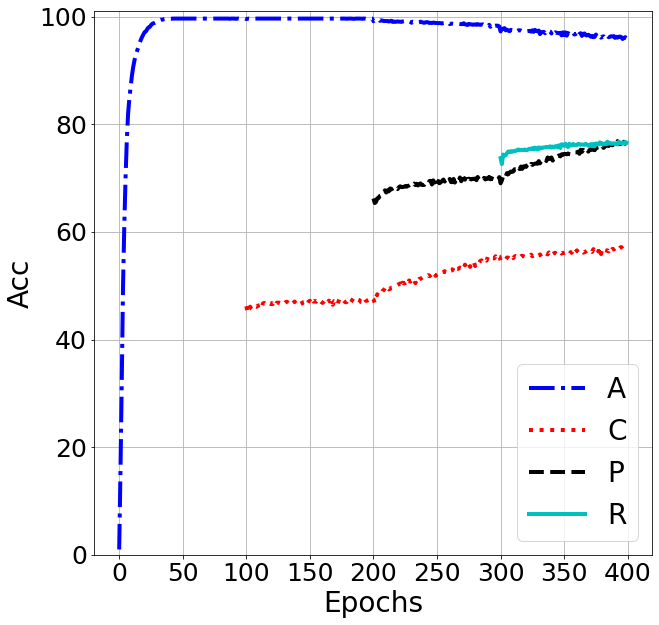

In [56]:
fig,ax=plt.subplots(1,figsize=(10,10))


plt.plot(Results1, '-.b', linewidth=4.0, label='A')

plt.plot(list(range(100,400)),Results2[100:], ':r', linewidth=4.0, label='C')

plt.plot(list(range(200,400)),Results3[200:], '--k', linewidth=4.0, label='P')

plt.plot(list(range(300,400)),Results4[300:], 'c', linewidth=4.0, label='R')


plt.legend(loc='lower right', fontsize=28)

plt.xlabel('Epochs', fontsize=28)
plt.ylabel('Acc', fontsize=28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0,101])
plt.grid()
plt.show()


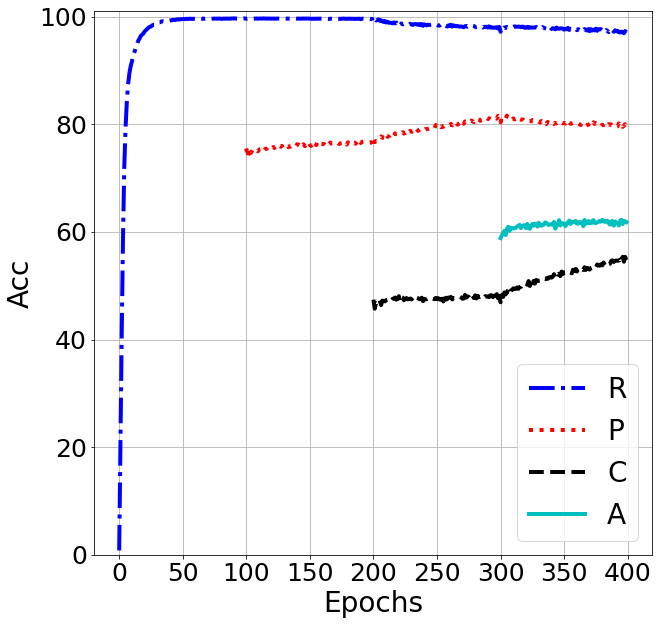

In [57]:
fig,ax=plt.subplots(1,figsize=(10,10))


plt.plot(Results11, '-.b', linewidth=4.0, label='R')

plt.plot(list(range(100,400)),Results21[100:], ':r', linewidth=4.0, label='P')

plt.plot(list(range(200,400)),Results31[200:], '--k', linewidth=4.0, label='C')

plt.plot(list(range(300,400)),Results41[300:], 'c', linewidth=4.0, label='A')


plt.legend(loc='lower right', fontsize=28)

plt.xlabel('Epochs', fontsize=28)
plt.ylabel('Acc', fontsize=28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0,101])
plt.grid()
plt.show()
